# Задание Lite

Используйте готовый ноутбук с занятия:
1. Обучите автокодировщик на **10** выбранных вами красивых цифрах **5** и отредактируйте с помощью него все остальные цифры **5**
2. Напишите **3** автокодировщика для подавления шума с собственными архитектурами. Сравните их между собой и с исходным шумоподавляющим автокодировщиком. Сравнивайте по квадрату разности исходной картинки с востановленной из шума
3. Обучите автокодировщик на базе **Fashion Mnist**, проверьте, как он преобразует картинки одежды, на которых не обучался

# Подключение библиотек

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Reshape, Conv2DTranspose, Activation, MaxPooling2D, Conv2D, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import time
import random
import os
import imageio

from IPython.display import Image
from google.colab import drive
sns.set_style('darkgrid')


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Создание функций

In [ ]:
# Функция создания автокодировщика

def baseAutoencoder(shape=(112,80,1)):
  img_input = Input((shape))   # Входные размеры

  x = Conv2D(32, (3,3), padding='same', activation='relu')(img_input)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  z = MaxPooling2D()(x)   

  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation='relu')(z)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(shape[-1], (3,3), padding='same', activation='sigmoid')(x)

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

  return model

In [ ]:
# Функция вывода изображения как картинок

def plotImages(xTrain, pred, shape=(112,80)):
  n = 5  # Кол-во картинок
  plt.figure(figsize=(14,7))  # Задаем фигуру и ее размер

  for i in range(n):
    index = np.random.randint(0, pred.shape[0])
    # Картинки из тестового набора
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xTrain[index].reshape(shape))
    ax.set_title(f'{index}')
    plt.gray()
    # Скрываем выводы координатных осей x и y. 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Восстановленные картинки
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(pred[index].reshape(shape))
    ax.set_title(f'{index}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()



In [ ]:
# Функция для расчета среднеквадратичной ошибки - mse
def getMSE(x1, x2):
  x1 = x1.flatten()
  x2 = x2.flatten()
  delta = x1 - x2
  return sum(delta**2) / len(delta)

In [ ]:
# Функция добавления шума
def addNoise(x, noiseVal):
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape)
  return np.clip(x + noiseVal * noise, 0., 1)

In [ ]:
# Callback для изменения шага обучения
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)

# Задание **1**. 

Обучите автокодировщик на **10** выбранных вами красивых цифрах **5** и отредактируйте с помощью него все остальные цифры **5**

NMIST

In [ ]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Посмотрим на размер предоставленной выборки 
print(xTrainMnist.shape)
print(yTrainMnist.shape)
print(xTestMnist.shape)
print(yTestMnist.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


##  Подготовка данных xTrain

In [ ]:
# Посмотрим на маску в yTrain, там где цифра 5 будет значение True
yTrainMnist==5

array([ True, False, False, ...,  True, False, False])

In [ ]:
# Применим данную маску к xTrain и создадим массив состоящий только из одних пятерок 
xTrain_5 = xTrainMnist[yTrainMnist==5]

# Посмотрим на размер 
print(xTrain_5.shape)
print("Количество цифр 5 в базе Mnist: ", xTrain_5.shape[0])

(5421, 28, 28)
Количество цифр 5 в базе Mnist:  5421


## Поиск красивых цифр 5

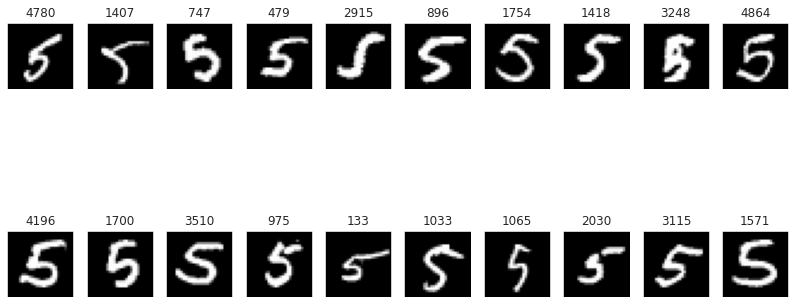

In [ ]:
# С помощью цикла можно выводить по 20 цифр с их индексами. Чтобы можно было составить список из 10 понравившихся
# Картинки будут выводиться рандомно.

plt.figure(figsize=(14,7))
n = 10
for i in range(n):
    index = np.random.randint(0, xTrain_5.shape[0])
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xTrain_5[index].reshape(28,28))
    ax.set_title(f'{index}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    index = np.random.randint(0, xTrain_5.shape[0])
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(xTrain_5[index].reshape(28,28))
    ax.set_title(f'{index}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [ ]:
# Индексы красивых пятерок
xTrainBest_5_indexes = [2281, 4794, 2678, 5410, 2857, 5246, 780, 4990, 87, 4366]

## Создание массивов без красивых 5 и только красивые 5

In [ ]:
# Создадим numpy массив в котором будут только 10 красивых пятерок
Best_5 = xTrain_5[xTrainBest_5_indexes]                                  # Используем индексы выше

# Посмотрим на размер 
print("Размер массива в котором только красивые пятерки: ", Best_5.shape)

print("Количество красивые пятерок в массиве: ", Best_5.shape[0])

print("Тип: ",type(Best_5))


Размер массива в котором только красивые пятерки:  (10, 28, 28)
Количество красивые пятерок в массиве:  10
Тип:  <class 'numpy.ndarray'>


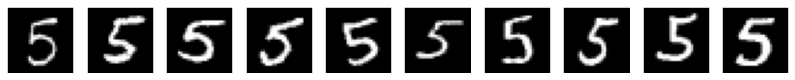

In [ ]:
# Посмотрим на все эти отобранные пятерки

plt.figure(figsize=(14,7))
n = 10
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(Best_5[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Подготовка данных (удаление, увеличение)

In [ ]:
# Теперь нужно удалить данные пятерки из обучающей выборки xTrain_5
# Используем функцию delete. Передаем массив из которого нужно удалить и вторым аргументом список индексов. Так же по какой оси

xTrain_no_best_5 = np.delete(xTrain_5, xTrainBest_5_indexes, axis=0)


In [ ]:
# Посмотрим на результат
print("Размер массива в котором отсутствуют красивые пятерки: ", xTrain_no_best_5.shape)
print("Тип: ",type(xTrain_no_best_5))

# Получился массив на 10 элементов меньше чем изначальный (5421 - 10 = 5411) 

Размер массива в котором отсутствуют красивые пятерки:  (5411, 28, 28)
Тип:  <class 'numpy.ndarray'>


In [ ]:
# Для того чтобы подать массив только из лучших пятерок в сеть, нужно привести до размера обучающей выборки, а именно сделать (5411, 28, 2)

xTrainBest_5 = np.repeat(Best_5, 541, axis=0)

In [ ]:
# Посмотрим на результат
xTrainBest_5.shape

(5410, 28, 28)

In [ ]:
# Так как в функции repeat было повторение 10 цифр по 541, то есть кратно 10, то добиться размера 5411 не получится. 
# Для точного совпадения массивов из массива в котором отсутствуют красивые пятерки удалим одно значение. 

xTrain_no_best_5 = np.delete(xTrain_no_best_5, 0, axis=0)

In [ ]:
# Посмотрим на конечный результат создания выборок

print("Массив в котором отсутствуют красивые пятерки:              ", xTrain_no_best_5.shape)
print("Массив состоящий из красивых пятерок (размноженный 541 раз):", xTrainBest_5.shape)

Массив в котором отсутствуют красивые пятерки:               (5410, 28, 28)
Массив состоящий из красивых пятерок (размноженный 541 раз): (5410, 28, 28)


## Тоже самое для xTest

In [ ]:
# Посмотрим на маску в yTest, там где цифра 5 будет значение True
yTestMnist==5

array([False, False, False, ..., False,  True, False])

In [ ]:
# Применим данную маску к xTrain и создадим массив состоящий только из одних пятерок 
xTest_5 = xTestMnist[yTestMnist==5]

# Посмотрим на размер 
print(xTest_5.shape)
print("Количество цифр 5 в тестовой выборке Mnist: ", xTest_5.shape[0])

(892, 28, 28)
Количество цифр 5 в тестовой выборке Mnist:  892


In [ ]:
# Так же для тестовой выборки нужно сделать 892 набора красивых пятерок. Но так как данный набор будет дублироваться, то
# сделаем массив кратным 10. То есть удалим две цифры 5 из тестовой выборки, чтобы она стала размером 890

xTest_5 = np.delete(xTest_5, [0,1], axis=0)

# Посмотрим на размер 
print(xTest_5.shape)

(890, 28, 28)


In [ ]:
# Для того чтобы подать массив, нужно привести до размера тестовой выборки, а именно сделать (890, 28, 28)
yTestBest_5 = np.repeat(Best_5, 89, axis=0)

In [ ]:
# Посмотрим на конечный результат создания выборок в тестовом наборе

print("Тестовый набор состоящий только из пятерок :               ", xTest_5.shape)
print("Массив состоящий из красивых пятерок (размноженный 89 раз):", yTestBest_5.shape)

Тестовый набор состоящий только из пятерок :                (890, 28, 28)
Массив состоящий из красивых пятерок (размноженный 89 раз): (890, 28, 28)


## Нормализация

In [ ]:
# Нормализуем данные в виде значений от 0 до 1 и меняем размерность 
xTrain_no_best_5 = xTrain_no_best_5.astype('float32') / 255
xTrain_no_best_5 = xTrain_no_best_5.reshape(-1, 28, 28, 1)
xTrain_no_best_5.shape

(5410, 28, 28, 1)

In [ ]:
# Аналогично для красивых пятерок
xTrainBest_5 = xTrainBest_5.astype('float32') / 255
xTrainBest_5 = xTrainBest_5.reshape(-1, 28, 28, 1)
xTrainBest_5.shape

(5410, 28, 28, 1)

In [ ]:
# Для тестовой выбоки, которая состоит только из пятерок
xTest_5 = xTest_5.astype('float32') / 255
xTest_5 = xTest_5.reshape(-1, 28, 28, 1)
xTest_5.shape

(890, 28, 28, 1)

In [ ]:
yTestBest_5 = yTestBest_5.astype('float32') / 255
yTestBest_5 = yTestBest_5.reshape(-1, 28, 28, 1)
yTestBest_5.shape

(890, 28, 28, 1)

In [ ]:
# Посмотрим на финальный размер выборок 
print(xTrain_no_best_5.shape)            # Только пятерки в обучающей выборке  
print(xTrainBest_5.shape)                # Размноженные красивые пятерки 
print(xTest_5.shape)                     # Только пятерки в тестовой выборке  
print(yTestBest_5.shape)                 # Размноженные красивые пятерки в тестовой выборке

(5410, 28, 28, 1)
(5410, 28, 28, 1)
(890, 28, 28, 1)
(890, 28, 28, 1)


## Создание автокодировщика и обучение

In [ ]:
# Создание автокодировщика
modelAutoMnist_5 = baseAutoencoder(shape=(28,28,1))

In [ ]:
historyMnist = modelAutoMnist_5.fit(xTrain_no_best_5, xTrainBest_5, epochs=300, batch_size=25, validation_data=(xTest_5, yTestBest_5), callbacks=[reduce_lr])

Epoch 1/300
217/217 [==============================] - 35s 24ms/step - loss: 0.1373 - val_loss: 0.0919
Epoch 2/300
217/217 [==============================] - 5s 21ms/step - loss: 0.0756 - val_loss: 0.0733
Epoch 3/300
217/217 [==============================] - 5s 21ms/step - loss: 0.0613 - val_loss: 0.0580
Epoch 4/300
217/217 [==============================] - 5s 21ms/step - loss: 0.0543 - val_loss: 0.0523
Epoch 5/300
217/217 [==============================] - 5s 21ms/step - loss: 0.0498 - val_loss: 0.0479
Epoch 6/300
217/217 [==============================] - 5s 21ms/step - loss: 0.0467 - val_loss: 0.0453
Epoch 7/300
217/217 [==============================] - 5s 21ms/step - loss: 0.0446 - val_loss: 0.0446
Epoch 8/300
217/217 [==============================] - 5s 21ms/step - loss: 0.0431 - val_loss: 0.0440
Epoch 9/300
217/217 [==============================] - 5s 21ms/step - loss: 0.0422 - val_loss: 0.0433
Epoch 10/300
217/217 [==============================] - 5s 21ms/step - loss: 0.04

In [ ]:
# Сохраним полученные веса
# modelAutoMnist_5.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoMnist_5.h5')
# Для загрузки весов
# modelAutoMnist_5.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoMnist_5.h5')

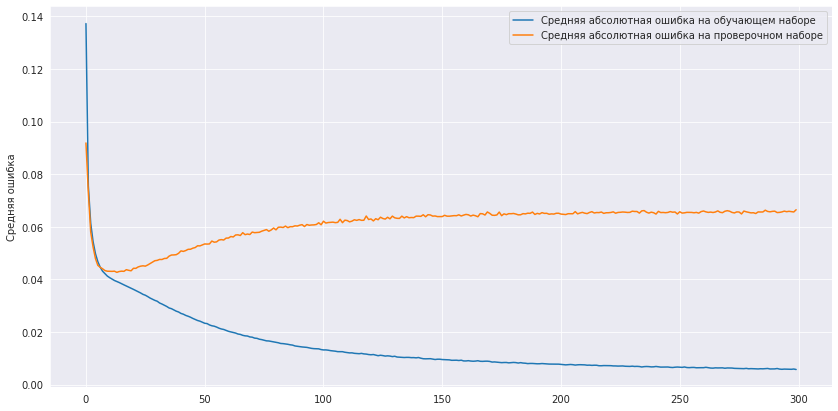

In [ ]:
# Графики
plt.figure(figsize=(14,7))
plt.plot(historyMnist.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(historyMnist.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Результат работы сети

In [ ]:
# Получаем результат работы на тестовой выборке
predMnist = modelAutoMnist_5.predict(xTest_5)

# Представляем в виде значений от 0 до 255
predMnist = predMnist * 255

# Установка нового типа
predMnist = predMnist.astype('uint8')

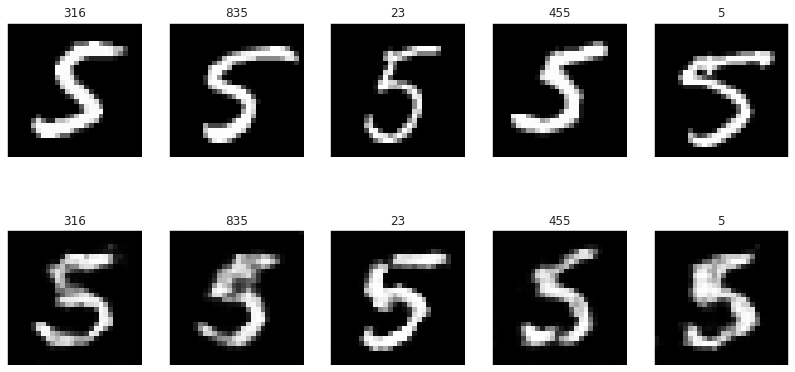

In [ ]:
# Посмотрим на исходные и восстановленные картинки
plotImages(xTest_5, predMnist, shape=(28,28))

# Задание 2. 
Напишите **3** автокодировщика для подавления шума с собственными архитектурами. Сравните их между собой и с исходным шумоподавляющим автокодировщиком. Сравнивайте по квадрату разности исходной картинки с востановленной из шума.

## Лица

In [ ]:
!unzip -q '/content/drive/MyDrive/УИИ/Автокодировщики/База лица/Лица.zip'     

In [ ]:
images_dir = 'Лица'   
img_height = 112      
img_width = 80  

In [ ]:
# Функция загрузки изображения
def load_images(images_dir, img_height, img_wight):
  list_images = []
  for img in os.listdir(images_dir):
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images)

In [ ]:
xTrain_imag = load_images(images_dir, img_height, img_width)

# Нормирование данных от 0 до 1
xTrain_img = xTrain_imag / 255

print("Загрузка завершена успешно")

Загрузка завершена успешно


**Так как в задании нужно подавить шум из картинок, то в начале этот шум нужно добавить. Для этого создадим дополнительные функции.**

In [ ]:
# Создаем зашумленный вариант лиц из xTrain_img
noisedXTrainFace = addNoise(xTrain_img, 0.1)

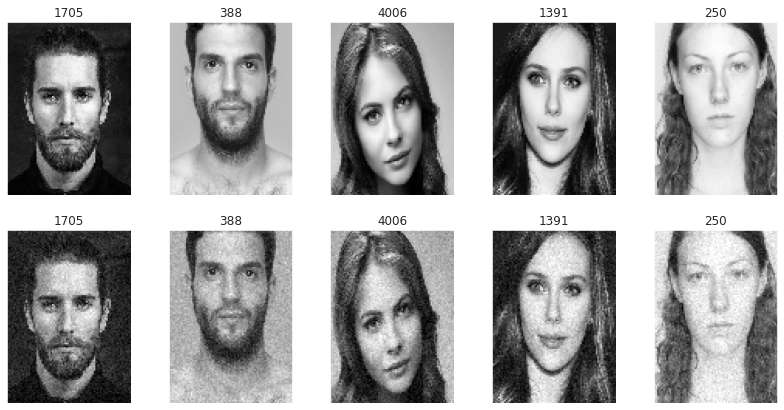

In [ ]:
# выведем на экран исходные лица и зашумленные варианты 
plotImages(xTrain_img, noisedXTrainFace)

### Обучение на исходном автокодировщике для сравнения с остальными

In [ ]:
# Объявляем функцию создания автокодировщика для подавления шума

def denoiseAutoencoderBase():
  img_input = Input((112,80,1))

  # Вместо MaxPooling используем strides
  x = Conv2D(32,  (3,3), strides=2, activation='relu', padding='same')(img_input)   # Размер (56,40)
  x = Conv2D(64,  (3,3), strides=2, activation='relu', padding='same')(x)           # Размер (28,20)
  x = Conv2D(128, (3,3), strides=2, activation='relu', padding='same')(x)           # Размер (14,10)
  x = Conv2D(256, (3,3), strides=2, activation='relu', padding='same')(x)           # Размер (7,5)

  #  Одномерный вектор - размер 7*5*256
  x = Flatten()(x)
  z = Dense(256, activation='relu')(x)

  # Переводим в 8960-мерное пространство(7*5*256)
  x = Dense(7*5*256, activation='relu')(z)

  # Меняем размеры - (7,5,256)
  x = Reshape((7,5,256))(x)

  # Разжимаем картинки
  x = Conv2DTranspose(256, (3,3), strides=2, padding='same')(x)                     # Размер (14,10)
  x = Conv2DTranspose(128, (3,3), strides=2, padding='same')(x)                     # Размер (28,20)
  x = Conv2DTranspose(64,  (3,3), strides=2, padding='same')(x)                     # Размер (56,40)
  x = Conv2DTranspose(32,  (3,3), strides=2, padding='same')(x)                     # Размер (112,80)`

  x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

  model = Model(img_input, x)

  model.compile(optimizer='adam', loss='mse')

  return model


In [ ]:
modelDenoiseFaceBase = denoiseAutoencoderBase()

### Обучение сети

In [ ]:
modelDenoiseFaceBase.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=150, batch_size=100, validation_data=(noisedXTrainFace[4700:], xTrain_img[4700:]))

Epoch 1/150
47/47 [==============================] - 39s 183ms/step - loss: 0.0527 - val_loss: 0.0325
Epoch 2/150
47/47 [==============================] - 8s 175ms/step - loss: 0.0233 - val_loss: 0.0183
Epoch 3/150
47/47 [==============================] - 8s 175ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 4/150
47/47 [==============================] - 8s 176ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 5/150
47/47 [==============================] - 8s 177ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 6/150
47/47 [==============================] - 8s 177ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 7/150
47/47 [==============================] - 8s 177ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 8/150
47/47 [==============================] - 8s 176ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 9/150
47/47 [==============================] - 8s 177ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 10/150
47/47 [==============================] - 8s 176ms/step - loss: 0.0079 - val_l

In [ ]:
# Сохраняем модель
# modelDenoiseFaceBase.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelDenoiseFaceBase.h5')

# При желании загружаем
# modelDenoiseFaceBase.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelDenoiseFaceBase.h5')

In [ ]:
predFaceDenoiseBase = modelDenoiseFaceBase.predict(noisedXTrainFace)    # Предикт шумовых картинок
predFaceDenoiseBase = predFaceDenoiseBase * 255  
predFaceDenoiseBase = predFaceDenoiseBase.astype('uint8') # 8 битовый тип

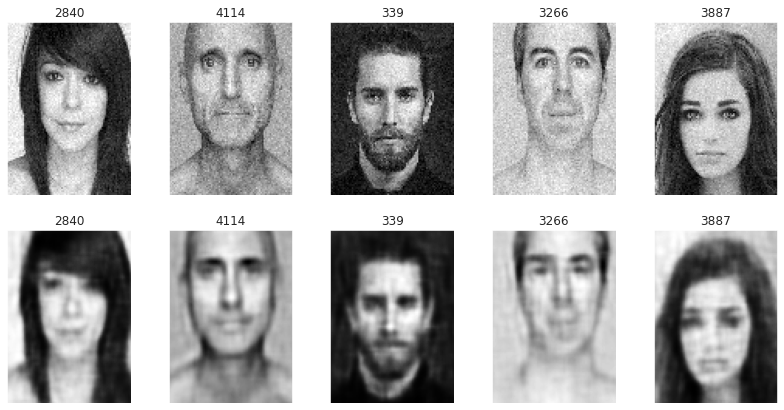

In [ ]:
# Шумоподавление на зашумленных картинках
plotImages(noisedXTrainFace, predFaceDenoiseBase)

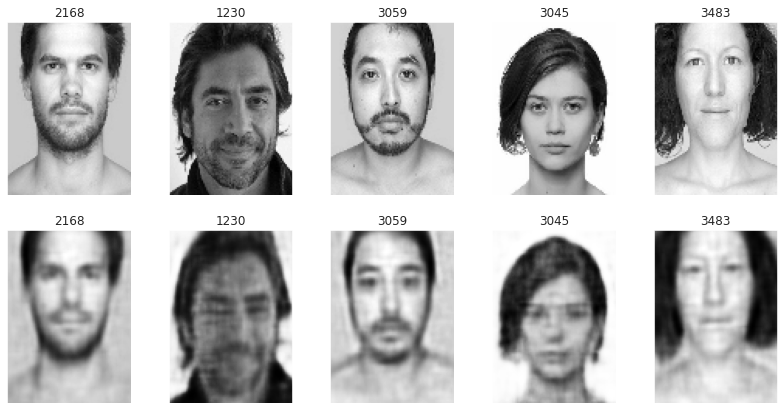

In [ ]:
# Шумоподавление на чистых лицах
plotImages(xTrain_img, predFaceDenoiseBase)

In [ ]:
# Среднеквадратичные ошибки для Лиц 
errNoiseBase = [getMSE(noisedXTrainFace[i], predFaceDenoiseBase[i] / 255) for i in range(len(predFaceDenoiseBase))]
meanErrNoiseBase = round(sum(errNoiseBase) / len(errNoiseBase), 4 )
maxErrNoiseBase = round(max(errNoiseBase), 4)
minErrNoiseBase = round(min(errNoiseBase), 4)
print("Средняя ошибка на Лицах:", meanErrNoiseBase)
print("Максимальная ошибка на Лицах:", maxErrNoiseBase)
print("Минимальная ошибка на Лицах:", minErrNoiseBase)

Средняя ошибка на Лицах: 0.0093
Максимальная ошибка на Лицах: 0.0436
Минимальная ошибка на Лицах: 0.0037


### Добавление данных в таблицу

In [ ]:
# Создание новой таблицы
data = pd.DataFrame(columns= ['Средняя ошибка(Mean)','Mаксимальная ошибка(Max)','Минимальная ошибка(Min)'])

In [ ]:
data.loc['modelDenoiseFaceBase'] = [meanErrNoiseBase, maxErrNoiseBase, minErrNoiseBase]

In [ ]:
data

,Средняя ошибка(Mean),Mаксимальная ошибка(Max),Минимальная ошибка(Min)
modelDenoiseFaceBase,0.0093,0.0436,0.0037


## **Первая** версия автокодировщика

**Уменьшим кол-во слоев свертки и добавим Dense слои**

In [ ]:
def modelDenoiseFaceMyVer1():
  img_input = Input((112,80,1))

  x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(img_input)    # Размер (56,40)
  x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)            # Размер (28,20)

  x = Flatten()(x)                     #  Одномерный вектор - размер 28*20*256
  x = Dense(256, activation='relu')(x) # добавляем полносвязный слой

  z = Dense(128, activation='relu')(x)
   
  x = Dense(256, activation='relu')(z)  # добавляем полносвязный слой

  # Переводим в 143360-мерное пространство(28*20*256)
  x = Dense(28*20*256, activation='relu')(x)
  
  x = Reshape((28,20,256))(x)
  x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)                       # Размер (56,40)
  x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)                       # Размер (112,80)
  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

  model = Model(img_input, x) 
  model.compile(optimizer='adam', loss='mse')

  return model


In [ ]:
modelDenoiseFaceMyVer1 = modelDenoiseFaceMyVer1()

### Модель сети

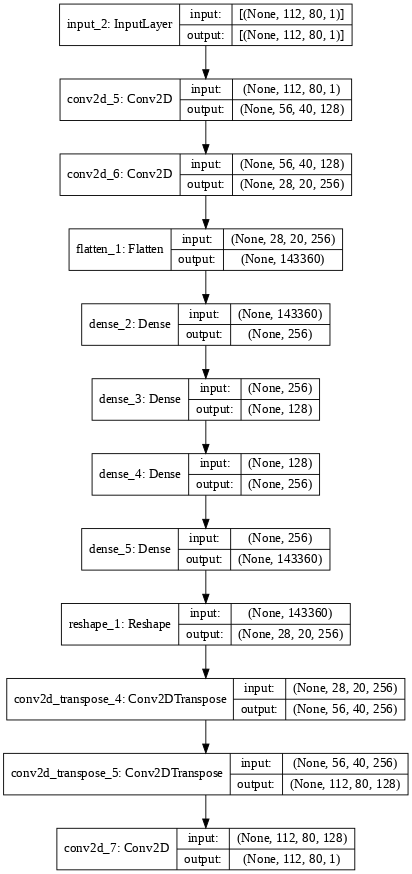

In [ ]:
plot_model(modelDenoiseFaceMyVer1, dpi=65, show_shapes=True)

### Обучение сети Ver 1

In [ ]:
modelDenoiseFaceMyVer1.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=150, batch_size=100, validation_data=(noisedXTrainFace[4700:], xTrain_img[4700:]))

Epoch 1/150
47/47 [==============================] - 39s 727ms/step - loss: 0.0548 - val_loss: 0.0355
Epoch 2/150
47/47 [==============================] - 34s 721ms/step - loss: 0.0275 - val_loss: 0.0237
Epoch 3/150
47/47 [==============================] - 34s 728ms/step - loss: 0.0201 - val_loss: 0.0190
Epoch 4/150
47/47 [==============================] - 34s 725ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 5/150
47/47 [==============================] - 34s 729ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 6/150
47/47 [==============================] - 34s 728ms/step - loss: 0.0124 - val_loss: 0.0136
Epoch 7/150
47/47 [==============================] - 34s 725ms/step - loss: 0.0116 - val_loss: 0.0122
Epoch 8/150
47/47 [==============================] - 34s 727ms/step - loss: 0.0107 - val_loss: 0.0119
Epoch 9/150
47/47 [==============================] - 34s 726ms/step - loss: 0.0101 - val_loss: 0.0123
Epoch 10/150
47/47 [==============================] - 34s 726ms/step - loss: 0.009

In [ ]:
# Сохраняем модель
# modelDenoiseFaceMyVer1.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelDenoiseFaceMyVer1.h5')

# При желании загружаем
# modelDenoiseFaceMyVer1.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelDenoiseFaceMyVer1.h5')

In [ ]:
predFaceDenoiseVer1 = modelDenoiseFaceMyVer1.predict(noisedXTrainFace)    # Предикт шумовых картинок
predFaceDenoiseVer1 = predFaceDenoiseVer1 * 255  
predFaceDenoiseVer1 = predFaceDenoiseVer1.astype('uint8') # 8 битовый тип

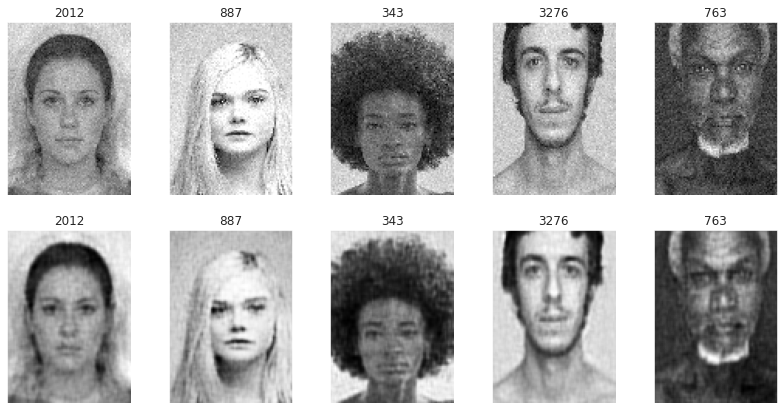

In [ ]:
# Шумоподавление на зашумленных картинках
plotImages(noisedXTrainFace, predFaceDenoiseVer1)

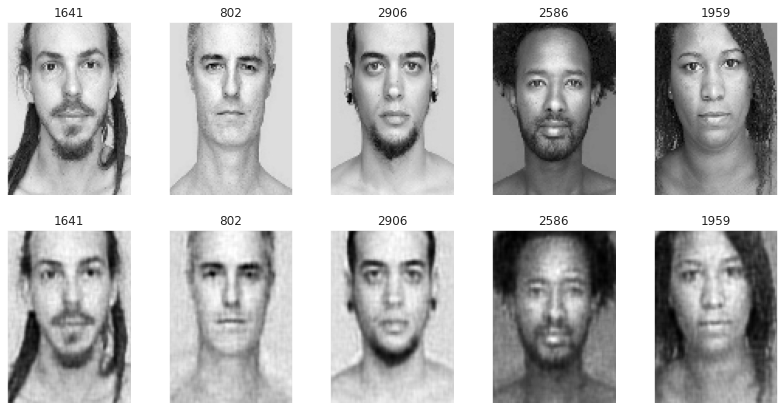

In [ ]:
# Шумоподавление на чистых лицах
plotImages(xTrain_img, predFaceDenoiseVer1)

In [ ]:
# Среднеквадратичные ошибки для Лиц 
errNoiseFaceVer1 = [getMSE(noisedXTrainFace[i], predFaceDenoiseVer1[i] / 255) for i in range(len(predFaceDenoiseVer1))]
meanErrNoiseVer1 = round(sum(errNoiseFaceVer1) / len(errNoiseFaceVer1), 4 )
maxErrNoiseVer1 = round(max(errNoiseFaceVer1), 4)
minErrNoiseVer1 = round(min(errNoiseFaceVer1), 4)
print("Средняя ошибка на Лицах:", meanErrNoiseVer1)
print("Максимальная ошибка на Лицах:", maxErrNoiseVer1)
print("Минимальная ошибка на Лицах:", minErrNoiseVer1)

Средняя ошибка на Лицах: 0.0077
Максимальная ошибка на Лицах: 0.0532
Минимальная ошибка на Лицах: 0.0025


### Добавление данных в таблицу

In [ ]:
data.loc['modelDenoiseFaceMyVer1'] = [meanErrNoiseVer1, maxErrNoiseVer1, minErrNoiseVer1]

In [ ]:
data

,Средняя ошибка(Mean),Mаксимальная ошибка(Max),Минимальная ошибка(Min)
modelDenoiseFaceBase,0.0093,0.0436,0.0037
modelDenoiseFaceMyVer1,0.0077,0.0532,0.0025


## **Вторая** версия автокодировщика

**Уберем два Dense слоя, добавим еще одну свертку и BatchNormalization**

In [ ]:
def modelDenoiseFaceMyVer2():
  img_input = Input((112,80,1))

  x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(img_input)    # Размер (56,40)
  x = BatchNormalization()(x)
  x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)            # Размер (28,20)
  x = BatchNormalization()(x)
  x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)            # Размер (14,10)
  x = BatchNormalization()(x)

  x = Flatten()(x)                     #  Одномерный вектор - размер 14*10*256
 
  z = Dense(128, activation='relu')(x)
  x = BatchNormalization()(z)

  # Переводим в 35840-мерное пространство(14*10*256)
  x = Dense(14*10*256, activation='relu')(x)
  x = BatchNormalization()(x)

  x = Reshape((14,10,256))(x)

  x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)                       # Размер (28,20)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)                       # Размер (56,40)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)                       # Размер (112,80)
  x = BatchNormalization()(x)
  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

  model = Model(img_input, x) 
  model.compile(optimizer='adam', loss='mse')

  return model


In [ ]:
modelDenoiseFaceMyVer2 = modelDenoiseFaceMyVer2()

### Модель сети

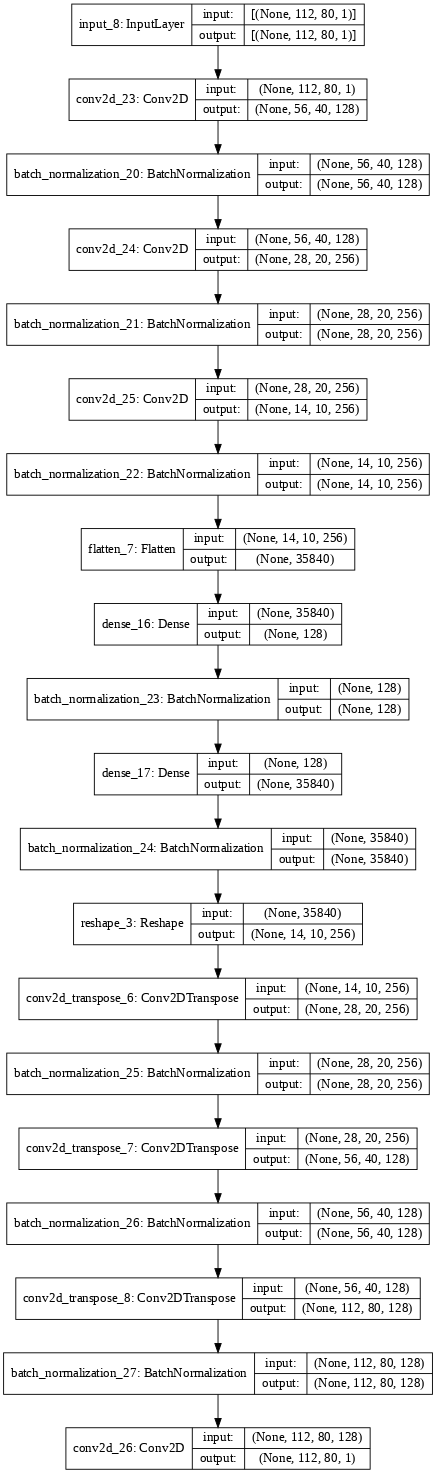

In [ ]:
plot_model(modelDenoiseFaceMyVer2, dpi=65, show_shapes=True)

### Обучение сети Ver 2

In [ ]:
modelDenoiseFaceMyVer2.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=150, batch_size=100, validation_data=(noisedXTrainFace[4700:], xTrain_img[4700:]))

Epoch 1/150
47/47 [==============================] - 62s 612ms/step - loss: 0.0312 - val_loss: 0.0628
Epoch 2/150
47/47 [==============================] - 28s 597ms/step - loss: 0.0158 - val_loss: 0.0608
Epoch 3/150
47/47 [==============================] - 28s 603ms/step - loss: 0.0125 - val_loss: 0.0582
Epoch 4/150
47/47 [==============================] - 29s 608ms/step - loss: 0.0107 - val_loss: 0.0569
Epoch 5/150
47/47 [==============================] - 29s 607ms/step - loss: 0.0098 - val_loss: 0.0561
Epoch 6/150
47/47 [==============================] - 28s 605ms/step - loss: 0.0090 - val_loss: 0.0560
Epoch 7/150
47/47 [==============================] - 28s 604ms/step - loss: 0.0087 - val_loss: 0.0507
Epoch 8/150
47/47 [==============================] - 28s 604ms/step - loss: 0.0082 - val_loss: 0.0470
Epoch 9/150
47/47 [==============================] - 28s 604ms/step - loss: 0.0077 - val_loss: 0.0416
Epoch 10/150
47/47 [==============================] - 28s 605ms/step - loss: 0.007

In [ ]:
# Сохраняем модель
# modelDenoiseFaceMyVer2.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelDenoiseFaceMyVer2.h5')

# При желании загружаем
# modelDenoiseFaceMyVer2.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelDenoiseFaceMyVer2.h5')

In [ ]:
predFaceDenoiseVer2 = modelDenoiseFaceMyVer2.predict(noisedXTrainFace)    # Предикт шумовых картинок
predFaceDenoiseVer2 = predFaceDenoiseVer2 * 255  
predFaceDenoiseVer2 = predFaceDenoiseVer2.astype('uint8') # 8 битовый тип

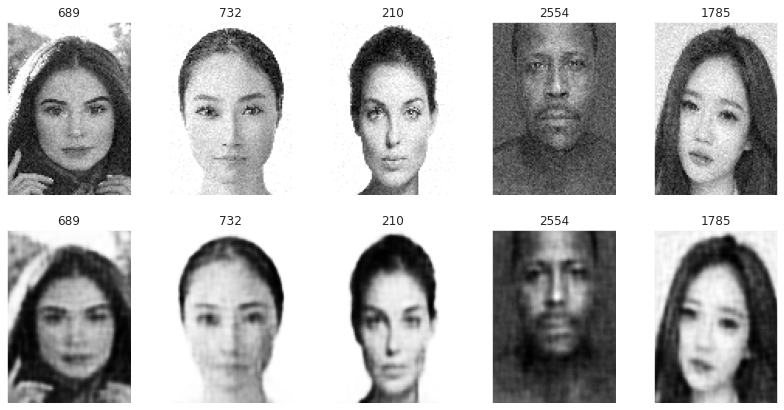

In [ ]:
# Шумоподавление на зашумленных картинках
plotImages(noisedXTrainFace, predFaceDenoiseVer2)

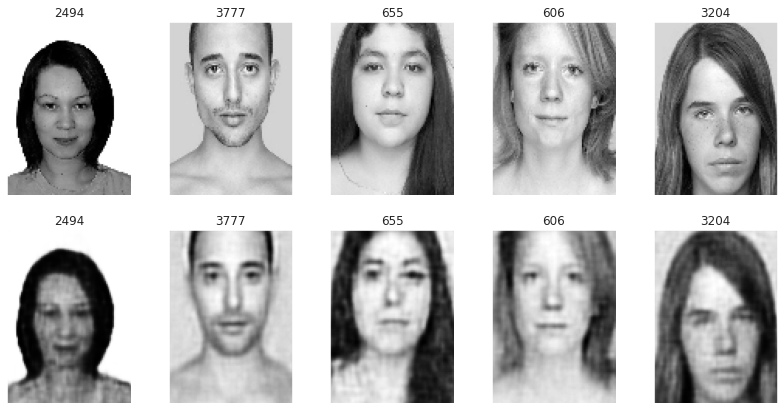

In [ ]:
# Шумоподавление на чистых лицах
plotImages(xTrain_img, predFaceDenoiseVer2)

In [ ]:
# Среднеквадратичные ошибки для Лиц 
errNoiseFaceVer2 = [getMSE(noisedXTrainFace[i], predFaceDenoiseVer2[i] / 255) for i in range(len(predFaceDenoiseVer2))]
meanErrNoiseVer2 = round(sum(errNoiseFaceVer2) / len(errNoiseFaceVer2), 4 )
maxErrNoiseVer2 = round(max(errNoiseFaceVer2), 4)
minErrNoiseVer2 = round(min(errNoiseFaceVer2), 4)
print("Средняя ошибка на Лицах:", meanErrNoiseVer2)
print("Максимальная ошибка на Лицах:", maxErrNoiseVer2)
print("Минимальная ошибка на Лицах:", minErrNoiseVer2)

Средняя ошибка на Лицах: 0.0079
Максимальная ошибка на Лицах: 0.1056
Минимальная ошибка на Лицах: 0.003


### Добавление данных в таблицу

In [ ]:
data.loc['modelDenoiseFaceMyVer2'] = [meanErrNoiseVer2, maxErrNoiseVer2, minErrNoiseVer2]

In [ ]:
data

,Средняя ошибка(Mean),Mаксимальная ошибка(Max),Минимальная ошибка(Min)
modelDenoiseFaceBase,0.0093,0.0436,0.0037
modelDenoiseFaceMyVer1,0.0077,0.0532,0.0025
modelDenoiseFaceMyVer2,0.0079,0.1056,0.0030


## **Третья** версия автокодировщика

**Вместо Strides будем использовать MaxPooling c добавлением еще одного слоя свертки и BatchNormalization**

In [ ]:
# Функция создания автокодировщика

def modelDenoiseFaceMyVer3():
  img_input = Input((112,80,1))   # Входные размеры

  x = Conv2D(32, (3,3), padding='same', activation='relu')(img_input)            # Размер (112, 80, 32)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)                                                          # Размер (56, 40, 32)

  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)                    # Размер (56, 40, 64)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)                                                          # Размер (28, 20, 64)                                 

  x = Conv2D(128, (3,3), padding='same', activation='relu')(x)                   # Размер (28, 20, 128)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)                                                          # Размер (14, 10, 128)

  x = Conv2D(256, (3,3), padding='same', activation='relu')(x)                   # Размер (14, 10, 256)
  x = BatchNormalization()(x)
  x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)                                                          # Размер (7, 5, 256)


  x = Flatten()(x)                                                               # Размер (8960)
 
  z = Dense(128, activation='relu')(x)                                           # Размер (128)
  x = BatchNormalization()(z)
  
  # Переводим в 8960-мерное пространство(7*5*256)
  x = Dense(7*5*256, activation='relu')(x)                                       # Размер (8960)
  x = BatchNormalization()(x)

  x = Reshape((7,5,256))(x)                                                      # Размер (7, 5, 256)

  x = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same', activation='relu')(x)  # Размер (14, 10, 256)
  x = BatchNormalization()(x)
  x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation='relu')(x)  # Размер (28, 20, 128)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation='relu')(x)  # Размер (56, 40, 64)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same', activation='relu')(x)  # Размер (112, 80, 32)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)                       # Размер (112, 80, 1)

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

  return model

In [ ]:
modelDenoiseFaceMyVer3 = modelDenoiseFaceMyVer3()

### Модель сети

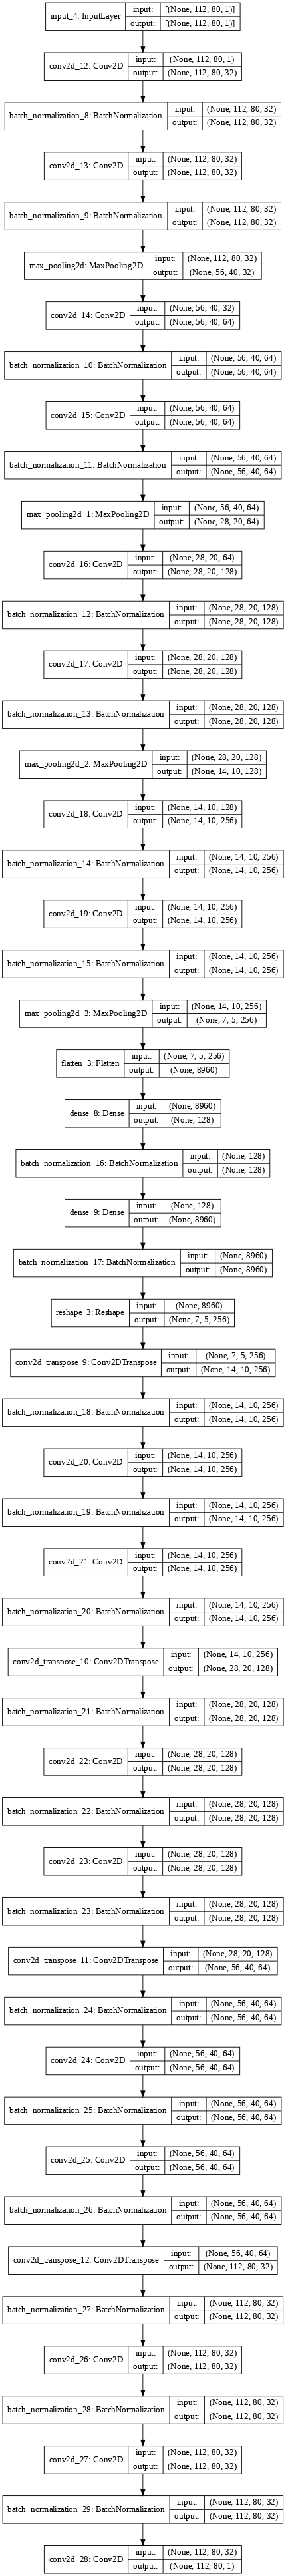

In [ ]:
plot_model(modelDenoiseFaceMyVer3, dpi=65, show_shapes=True)

### Обучение сети Ver 3

In [ ]:
modelDenoiseFaceMyVer3.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=150, batch_size=100, validation_data=(noisedXTrainFace[4700:], xTrain_img[4700:]))

Epoch 1/150
47/47 [==============================] - 26s 542ms/step - loss: 0.0333 - val_loss: 0.0682
Epoch 2/150
47/47 [==============================] - 25s 540ms/step - loss: 0.0222 - val_loss: 0.0686
Epoch 3/150
47/47 [==============================] - 25s 541ms/step - loss: 0.0182 - val_loss: 0.0689
Epoch 4/150
47/47 [==============================] - 25s 542ms/step - loss: 0.0163 - val_loss: 0.0697
Epoch 5/150
47/47 [==============================] - 25s 540ms/step - loss: 0.0149 - val_loss: 0.0688
Epoch 6/150
47/47 [==============================] - 25s 540ms/step - loss: 0.0140 - val_loss: 0.0655
Epoch 7/150
47/47 [==============================] - 25s 540ms/step - loss: 0.0132 - val_loss: 0.0625
Epoch 8/150
47/47 [==============================] - 25s 541ms/step - loss: 0.0127 - val_loss: 0.0555
Epoch 9/150
47/47 [==============================] - 25s 540ms/step - loss: 0.0124 - val_loss: 0.0405
Epoch 10/150
47/47 [==============================] - 25s 539ms/step - loss: 0.011

In [ ]:
# Сохраняем модель
# modelDenoiseFaceMyVer3.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelDenoiseFaceMyVer3.h5')

# При желании загружаем
# modelDenoiseFaceMyVer3.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelDenoiseFaceMyVer3.h5')

In [ ]:
predFaceDenoiseVer3 = modelDenoiseFaceMyVer3.predict(noisedXTrainFace)    # Предикт шумовых картинок
predFaceDenoiseVer3 = predFaceDenoiseVer3 * 255  
predFaceDenoiseVer3 = predFaceDenoiseVer3.astype('uint8') # 8 битовый тип

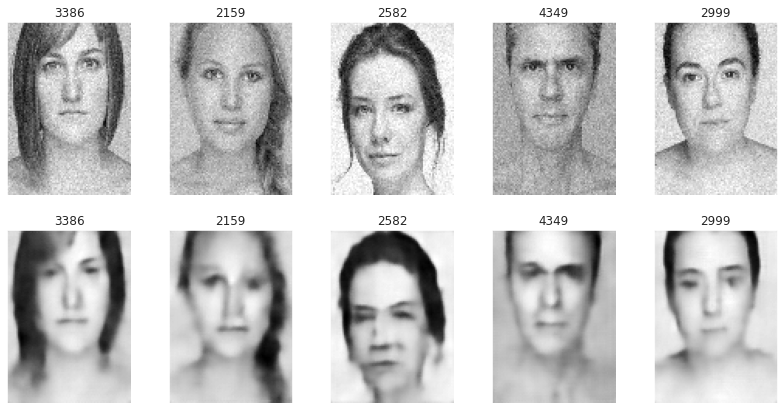

In [ ]:
# Шумоподавление на зашумленных картинках
plotImages(noisedXTrainFace, predFaceDenoiseVer3)

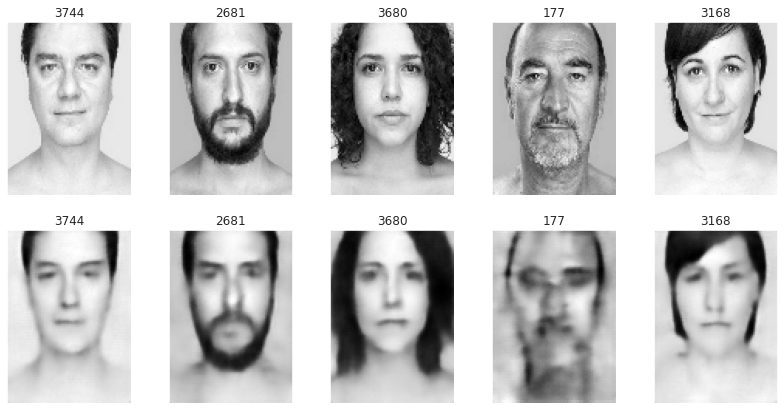

In [ ]:
# Шумоподавление на чистых лицах
plotImages(xTrain_img, predFaceDenoiseVer3)

In [ ]:
# Среднеквадратичные ошибки для Лиц 
errNoiseFaceVer3 = [getMSE(noisedXTrainFace[i], predFaceDenoiseVer3[i] / 255) for i in range(len(predFaceDenoiseVer3))]
meanErrNoiseVer3 = round(sum(errNoiseFaceVer3) / len(errNoiseFaceVer3), 4 )
maxErrNoiseVer3 = round(max(errNoiseFaceVer3), 4)
minErrNoiseVer3 = round(min(errNoiseFaceVer3), 4)
print("Средняя ошибка на Лицах:", meanErrNoiseVer3)
print("Максимальная ошибка на Лицах:", maxErrNoiseVer3)
print("Минимальная ошибка на Лицах:", minErrNoiseVer3)

Средняя ошибка на Лицах: 0.0101
Максимальная ошибка на Лицах: 0.0479
Минимальная ошибка на Лицах: 0.0043


### Добавление данных в таблицу

In [ ]:
data.loc['modelDenoiseFaceMyVer3'] = [meanErrNoiseVer3, maxErrNoiseVer3, minErrNoiseVer3]

## Общая таблица для всех опытов

In [ ]:
data

,Средняя ошибка(Mean),Mаксимальная ошибка(Max),Минимальная ошибка(Min)
modelDenoiseFaceBase,0.0093,0.0436,0.0037
modelDenoiseFaceMyVer1,0.0077,0.0532,0.0025
modelDenoiseFaceMyVer2,0.0079,0.1056,0.0030
modelDenoiseFaceMyVer3,0.0101,0.0479,0.0043


# Задание 3. 
Обучите автокодировщик на базе **Fashion Mnist**, проверьте, как он преобразует картинки одежды, на которых не обучался

In [ ]:
# Загрузим данные из базы
(xTrainMnistF, yTrainMnistF), (xTestMnistF, yTestMnist) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
xTrainMnistF = xTrainMnistF.astype('float32') / 255
xTrainMnistF = xTrainMnistF.reshape(xTrainMnistF.shape[0], 28, 28, 1)

In [ ]:
xTestMnistF = xTestMnistF.astype('float32') / 255
xTestMnistF = xTestMnistF.reshape(xTestMnistF.shape[0], 28, 28, 1)

## Без шума на тестовой выборке

**Для начала посмотрим как справится автокодировщик на тестовых картинках которых не видел, без добавления шума.**

In [ ]:
# Создаем автокодировщик
modelFashionMnist = baseAutoencoder((28, 28, 1))

# Обучение сети

In [ ]:
# Обучение автокодировщика
modelFashionMnist.fit(xTrainMnistF, xTrainMnistF, epochs=150, batch_size=256, validation_data=(xTestMnistF, xTestMnistF))

Epoch 1/150
235/235 [==============================] - 21s 91ms/step - loss: 0.0452 - val_loss: 0.1031
Epoch 2/150
235/235 [==============================] - 21s 88ms/step - loss: 0.0159 - val_loss: 0.0289
Epoch 3/150
235/235 [==============================] - 21s 89ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 4/150
235/235 [==============================] - 21s 89ms/step - loss: 0.0099 - val_loss: 0.0087
Epoch 5/150
235/235 [==============================] - 21s 89ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 6/150
235/235 [==============================] - 21s 89ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 7/150
235/235 [==============================] - 21s 89ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 8/150
235/235 [==============================] - 21s 89ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 9/150
235/235 [==============================] - 21s 90ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 10/150
235/235 [==============================] - 21s 89ms/step - l

In [ ]:
# Сохраняем модель
modelFashionMnist.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelFashionMnist.h5')

# При желании загружаем
# modelFashionMnist.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelFashionMnist.h5')

In [ ]:
# Получаем результат на тестовой выборке
predFashionMnist = modelFashionMnist.predict(xTestMnistF)
predFashionMnist = predFashionMnist * 255   # Перевод значений от 0 до 255
predFashionMnist = predFashionMnist.astype('uint8')

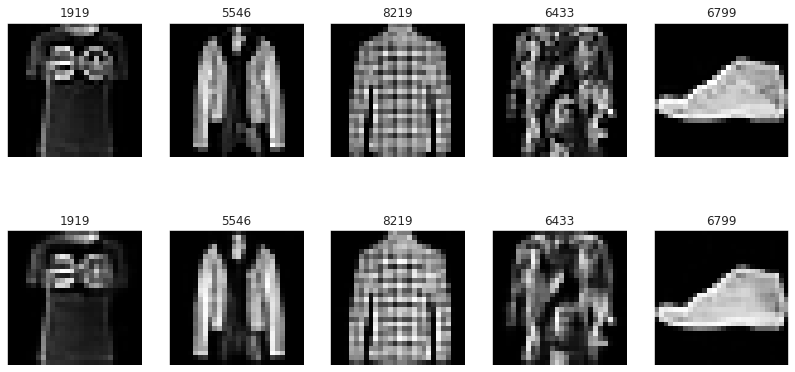

In [ ]:
# Посмотрим на исходные и восстановленные картинки на обучающей выборке
plotImages(xTestMnistF, predFashioMnist, shape=(28,28))

In [ ]:
# Среднеквадратичные ошибка
errFashionMnist = [getMSE(xTestMnistF[i], predFashionMnist[i] / 255) for i in range(len(predFashionMnist))]
MeanErrFashionMnist = round(sum(errFashionMnist) / len(errFashionMnist), 4 )
MaxErrFashionMnist = round(max(errFashionMnist), 4)
MinErrFashionMnist = round(min(errFashionMnist), 4)
print("Средняя ошибка:", MeanErrFashionMnist)
print("Максимальная ошибка:", MaxErrFashionMnist)
print("Минимальная ошибка:", MinErrFashionMnist)

Средняя ошибка: 0.0015
Максимальная ошибка: 0.039
Минимальная ошибка: 0.0002


## C добавлением шума

In [ ]:
# Создаем зашумленный вариант для XTrain и xTest с коэфициентом 0.3
noisedXFashioMnistTrain = addNoise(xTrainMnistF, 0.3)
noisedXFashioMnistTest = addNoise(xTestMnistF, 0.3)

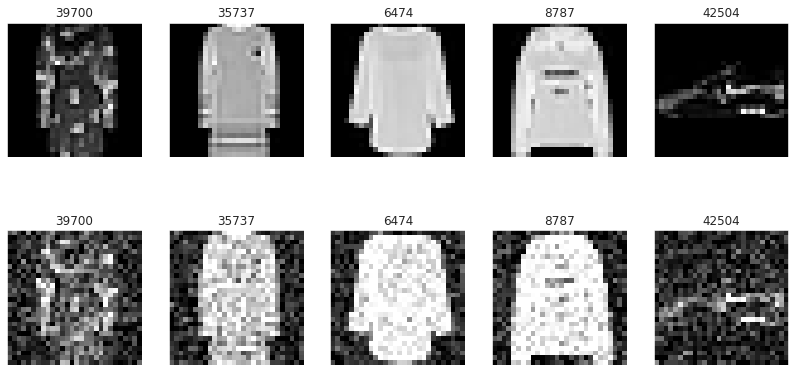

In [ ]:
# Выведем на экран исходные картинки и зашумленные варианты на обучающей выборке
plotImages(xTrainMnistF, noisedXFashioMnistTrain, shape=(28,28))

In [ ]:
# Создаем автокодировщик
modelFashionMnistNoised = baseAutoencoder((28, 28, 1))

**Посмотрим как справится автокодировщик восстанавливать зашумленные изображения**

# Обучение сети

In [ ]:
# Обучение автокодировщика
modelFashionMnistNoised.fit(noisedXFashioMnistTrain, xTrainMnistF , epochs=200, batch_size=256, validation_data=(noisedXFashioMnistTest,xTestMnistF))

Epoch 1/200
235/235 [==============================] - 44s 90ms/step - loss: 0.0379 - val_loss: 0.0634
Epoch 2/200
235/235 [==============================] - 21s 89ms/step - loss: 0.0161 - val_loss: 0.0271
Epoch 3/200
235/235 [==============================] - 21s 89ms/step - loss: 0.0125 - val_loss: 0.0118
Epoch 4/200
235/235 [==============================] - 21s 88ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 5/200
235/235 [==============================] - 21s 89ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 6/200
235/235 [==============================] - 21s 89ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 7/200
235/235 [==============================] - 21s 89ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 8/200
235/235 [==============================] - 21s 89ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 9/200
235/235 [==============================] - 21s 89ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 10/200
235/235 [==============================] - 21s 89ms/step - l

In [ ]:
# Сохраняем модель
modelFashionMnistNoised.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelFashionMnistNoised.h5')

# При желании загружаем
# modelFashionMnistNoised.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelFashionMnistNoised.h5')

In [ ]:
# Получаем результат на тестовой выборке (на которой сеть не обучалась)
predFashionMnistNoised = modelFashionMnistNoised.predict(noisedXFashioMnistTest)
predFashionMnistNoised = predFashionMnistNoised * 255   # Перевод значений от 0 до 255
predFashionMnistNoised = predFashionMnistNoised.astype('uint8')

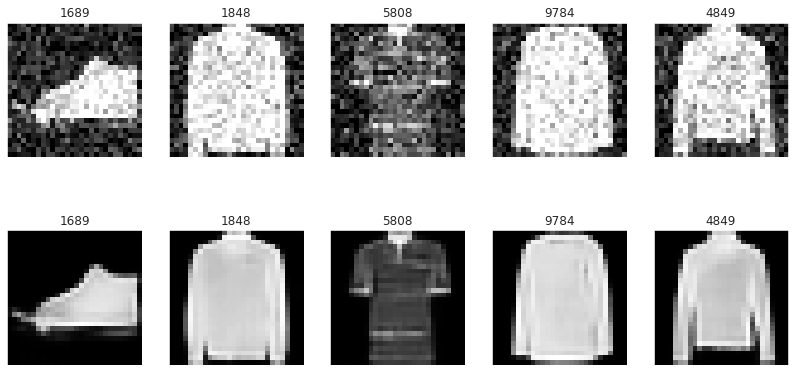

In [ ]:
# Посмотрим на зашумленные и восстановленные картинки (тестовая выборка)
plotImages(noisedXFashioMnistTest, predFashionMnistNoised, shape=(28,28))

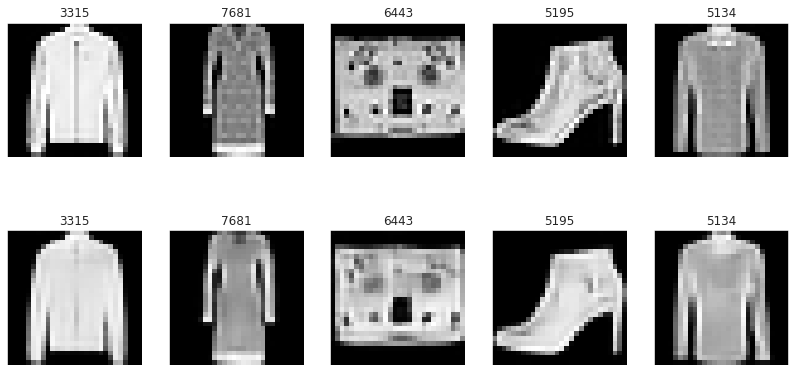

In [ ]:
# Посмотрим на исходные и восстановленные картинки тестовая выборка)
plotImages(xTestMnistF, predFashionMnistNoised, shape=(28,28))

In [ ]:
# Среднеквадратичные ошибка
errFashionMnistNoised = [getMSE(xTestMnistF[i], predFashionMnistNoised[i] / 255) for i in range(len(predFashionMnistNoised))]
MeanErrFashionMnistNoised = round(sum(errFashionMnistNoised) / len(errFashionMnistNoised), 4 )
MaxErrFashionMnistNoised = round(max(errFashionMnistNoised), 4)
MinErrFashionMnistNoised = round(min(errFashionMnistNoised), 4)
print("Средняя ошибка на зашумленных изображениях:", MeanErrFashionMnistNoised)
print("Максимальная ошибка изображениях:", MaxErrFashionMnistNoised)
print("Минимальная ошибка изображениях:", MinErrFashionMnistNoised)

Средняя ошибка на зашумленных изображениях: 0.0037
Максимальная ошибка изображениях: 0.0467
Минимальная ошибка изображениях: 0.0007


# Выводы:

1.  В первом задании требовалось обучить сеть на **10** красивых пятерках и с помощью их отредактировать остальные цифры пять. Результат показан ниже. 
   Если уменьшить шаг обучения и еще раз обучить сеть результат может быть немного лучше. Но в целом он заметен. Изначальные изображения пятерки на выходе изменились. 

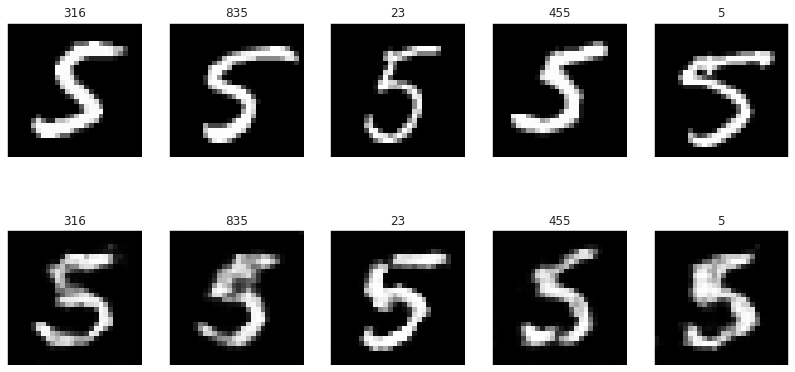

In [ ]:
# Посмотрим на исходные и восстановленные картинки
plotImages(xTest_5, predMnist, shape=(28,28))

3. Подавление шума на базе **Лиц**.
  Было опробовано **4** нейронные сети. Одна из задания и **3** своих. 

  **modelDenoiseFaceBase**    - Исходным шумоподавляющий автокодировщик

  **modelDenoiseFaceMyVer1**	- Первая версия сети

  **modelDenoiseFaceMyVer2**	- Вторая версия сети

  **modelDenoiseFaceMyVer3**	- Третья версия сети
  
  Результаты:

In [ ]:
data

,Средняя ошибка(Mean),Mаксимальная ошибка(Max),Минимальная ошибка(Min)
modelDenoiseFaceBase,0.0093,0.0436,0.0037
modelDenoiseFaceMyVer1,0.0077,0.0532,0.0025
modelDenoiseFaceMyVer2,0.0079,0.1056,0.0030
modelDenoiseFaceMyVer3,0.0101,0.0479,0.0043


4. По данному заданию можно сказать следующие:
    - Не всегда увеличение слоев и нейронов приводит к лучшему результату. 
      Как видно из таблицы нейронная сеть с **меньшим** кол-вом слоев показала **лучший** результат на средней ошибке.
    - Увеличение связей между нейронами приводит к **увеличению** времени обучения и **переполнению** памяти. Поэтому можно сдлеть меньшее кол-во экспериментов. 
    - Нужно идти от **простого** к сложному, а не наоборот. 
    - Не достаточно большая база для обучения если сравнивать с Mnist и Fashion Mnist. При большей обучающей базе результат был бы лучше. 

5. Задание по базе **Fashion Mnist**
  - Нейронная сеть показал неплохой результат для своей поставленной задаче
  - При не зашумленных картинках, результат на изображениях которые нейронная сеть не видела во время обучения:
      - Средняя ошибка: **0.0015**
      - Максимальная ошибка: **0.039**
      - Минимальная ошибка: **0.0002**
  - Если предварительно подать шум на обучающие и тестовые изображения, то в данной задаче так же нейронная сеть отлично справилась со своей задачей. На выходе изображения практически без шума. Результат: 
      - Средняя ошибка на зашумленных изображениях: **0.0037**
      - Максимальная ошибка изображениях: **0.0467**
      - Минимальная ошибка изображениях: **0.0007**